In [13]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.dates as mdates
from wordcloud import WordCloud, STOPWORDS 


In [7]:
df1 = pd.read_csv("vocop-clustered-new.csv", sep='\t') 
df = pd.DataFrame(df1)

D:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (17,27,35,36,38) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# import street map
street_map = gpd.read_file('Data Stories/ne_10m_admin_0_map_subunits/ne_10m_admin_0_map_subunits.shp')
border1 = gpd.read_file('Data Stories/ne_10m_admin_0_boundary_lines_land/ne_10m_admin_0_boundary_lines_land.shp')
border2 = gpd.read_file('Data Stories/ne_10m_admin_0_boundary_lines_map_units/ne_10m_admin_0_boundary_lines_map_units.shp')
land = gpd.read_file('Data Stories/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
ocean = gpd.read_file('Data Stories/ne_10m_ocean/ne_10m_ocean.shp')


DriverError: Data Stories/ne_10m_admin_0_map_subunits/ne_10m_admin_0_map_subunits.shp: No such file or directory

In [ ]:
# designate coordinate system
crs = {'init':'espc:4326'}

# zip x and y coordinates into single feature
geometry = [Point(xy) for xy in zip(df['LON'], df['LAT'])]

# create GeoPandas dataframe
geo_df = gpd.GeoDataFrame(df,
 crs = crs,
 geometry = geometry)

In [ ]:
from shapely.geometry import Point
# create figure and axes, assign to subplot
fig, ax = plt.subplots(figsize=(50,10))

# add .shp mapfile to axes
# street_map.plot(ax=ax, alpha=0.4,color='grey')
land.plot(ax=ax, alpha=0.4, color='grey')
border1.plot(ax=ax, alpha=0.4, color='black')
border2.plot(ax=ax, alpha=0.4, color='black')


# add geodataframe to axes
# assign ‘price’ variable to represent coordinates on graph
# add legend
# make datapoints transparent using alpha
# assign size of points using markersize
geo_df.plot(ax=ax,alpha=0.5, legend=True,markersize=5)

# add title to graph
plt.title('Place of Birth of employees', fontsize=15,fontweight='bold')

# set latitiude and longitude boundaries for map display
plt.xlim(-10,30)
plt.ylim(35,65)

#plot oceans
# ocean.plot(ax=ax, color='white')


# show map
plt.show()

In [ ]:
#count unique place of origine and the frequency
df_count = df.groupby('countryCode')['VOCOP_id'].nunique()
df_count = pd.DataFrame(df_count)


In [ ]:
#plot graph of most frequent country codes
fig, ax = plt.subplots(figsize=(100,60))
number = df['countryCode'].value_counts()
criteria = number[number >= 1000] #only frequencies greater than 1000
graph = pd.DataFrame(criteria)
graph.plot(ax=ax, kind='bar', align='center', alpha=0.5, legend=False)
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.title('Frequency of country codes greater than 1000')
plt.rcParams.update({'font.size': 100})
plt.legend('Frequency').set_visible(False)


In [ ]:
#plot graph of less frequent country codes
fig, ax = plt.subplots(figsize=(100,60))
number = df['countryCode'].value_counts()
criteria = number[number < 50] #only frequencies less than 50
graph = pd.DataFrame(criteria)
graph.plot(ax=ax, kind='bar', align='center', alpha=0.5, legend=False)
plt.xlabel('Country Code')
plt.ylabel('Frequency')
plt.title('Frequency of country codes less than 50')
plt.rcParams.update({'font.size': 100})
plt.legend('Frequency').set_visible(False)

Employees per time period


In [ ]:
# date_begin_service_complete 
# date_end_service_complete 
df_time = df.groupby('date_end_service_complete')['VOCOP_id'].nunique()


In [ ]:
# alles met een jaar voor 1633 of na 1794 kun je weglaten
df_time_filter = df[(df['date_begin_service_complete'] > '1632-12-31') & (df['date_begin_service_complete'] < '1795-01-01')]
df_time_filter_2 = df_time_filter[(df_time_filter['date_end_service_complete'] > '1632-12-31') & (df_time_filter['date_end_service_complete'] < '1795-01-01')]


In [ ]:
#create new datasets just containing the begin and end date
begin = df_time_filter_2['date_begin_service_complete']
end = df_time_filter_2['date_end_service_complete']


In [ ]:
#adjust begin and end dataset; make dataframes and transform into the right datetime format
import datetime
begin = pd.to_datetime(begin, format='%Y-%M-%d', errors = 'coerce')
begin = pd.DataFrame(begin)
begin.columns = ['begin_time']
end = pd.to_datetime(end, format='%Y-%M-%d', errors = 'coerce')
end = pd.DataFrame(end)
end.columns = ['end_time']

In [ ]:
#get rid of the time of the datetime format
begin['begin_time'] = begin['begin_time'].dt.strftime("%Y/%m/%d")
end['end_time'] = end['end_time'].dt.strftime("%Y/%m/%d")

In [ ]:
#resample using years and count the amount of beginning employees at the end of every year.
df_time_filter_2['date_begin_service_complete'] = pd.to_datetime(df_time_filter_2['date_begin_service_complete'], format='%Y', errors = 'coerce')
df_res_begin = df_time_filter_2.resample('Y', on='date_begin_service_complete').count()

In [ ]:
#get rid of all the unnecessary columns
df_res_begin = df_res_begin['VOCOP_id']


In [ ]:
#resample using years and count the amount of ending employees at the end of every year.
df_time_filter_2['date_end_service_complete'] = pd.to_datetime(df_time_filter_2['date_end_service_complete'], format='%Y', errors = 'coerce')
df_res_end = df_time_filter_2.resample('Y', on='date_end_service_complete').count()


In [ ]:
#get rid of all the unnecessary columns
df_res_end = df_res_end['VOCOP_id']


In [ ]:
#calculate the difference between the amount of people starting and ending their employment within a year. 
df_dif = df_res_begin - df_res_end


In [ ]:
#Plot the graph about the increase/decrease of employees over time. 
fig, ax = plt.subplots(figsize=(100,60))
df_dif.plot(ax=ax, kind='bar', legend=False)
plt.rcParams.update({'font.size': 50})
plt.xlabel('Years')
plt.ylabel('Amount of employees')
plt.title('Increase and decrease of the amount of employees over time')
plt.rcParams.update({'font.size': 100})
plt.legend('Frequency').set_visible(False)

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [ ]:
#plot the amount of employees over time within the VOC
df_cum = df_dif.cumsum()
fig, ax = plt.subplots(figsize=(100,60))
df_cum.plot(ax=ax, kind='bar', legend=False)
plt.rcParams.update({'font.size': 50})
plt.xlabel('Years')
plt.ylabel('Amount of employees')
plt.title('Amount of employees at the VOC over time')
plt.rcParams.update({'font.size': 80})
plt.legend('Frequency').set_visible(False)

every_nth = 10
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)


Search for right individual for the data stories

In [ ]:
#select individual who's career will be analyzed. 
proef2 = proef[proef['fullNameOriginal'] == 'Cornelis Vis'] 
df_proef = proef2[proef2['toponymCountryCode'] == 'Colijnsplaat NL']


In [ ]:
#service time in days per record and in total
from datetime import date

#index 52822
d1 = date(1734,11,22)
d2 = date(1737,6,30)

time1=d2-d1
print("Days of employement: ", time1)

#index 60688
d3 = date(1738,6,2)
d4 = date(1741,9,27)

time2=d4-d3
print("Days of employement: ",time2)

#index 66931
d5 = date(1744,12,9)
d6 = date(1748,9,2)

time3=d6-d5
print("Days of employement: ",time3)

#index 82692
d7 = date(1750,3,26)
d8 = date(1751,10,6)

time4=d8-d7
print("Days of employement: ",time4)

#Total days of servicetime
totaal = time1 + time2 + time3 + time4
print("Total amount of days of employment: ", totaal)

In [ ]:
#standard wage for individual per record in the dataset
df_proef['wageStandard_DASminSupplementedBeini']

In [ ]:
#HISCO codes for the individual per recor in the dataset
df_proef['HISCO_CODE']

In [9]:
#remove rows without a cluster id (do not have multiple records)
df_cluster = df[df['cluster_ID'].notnull()]


In [10]:
#sort rows on cluster id to group the records of each individual
df_cluster.sort_values(by=['cluster_ID'], inplace=True, ascending=True)


D:\Anaconda\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [379]:
#compare stardard wage of dataset with manually checked stardard wage to see if there is any variation
df_man1 = pd.read_csv("Data Stories/sample_VOCOP_manually.csv") 
df_man = pd.DataFrame(df_man1)


In [370]:
#vocop ids of individual were not found in this dataset.
var = df_man[df_man['VOCOP_id'] == '252036']
var

,VOCOP_id,rank,rank_NL,full_name,handle_scan,link,monthly_wage,correct_rank,remarks,country,rank_adjusted;


In [616]:
#difference in wage between different ranks in percentges.
#An increase of the wage has been defined as a promotion
#A decrease of the wage has been defined as a demotion.
#If there is no change in the wage, it is being defined as a 'no change'
dif_proef = (df_proef['wageStandard_DASminSupplementedBeini'].diff() / df_proef['wageStandard_DASminSupplementedBeini'].shift()) * 100
round(dif_proef, 2)
dif_proef = dif_proef.tolist()
dif_proef = list(np.around(np.array(dif_proef),2))

for x in dif_proef:
    if x>0:
        print('Promotion by ', x, ' percent')
    if x<0:
        print('Demotion by ', x, ' percent')
    if x==0:
        print('No change')

Promotion by  23.08  percent
Promotion by  212.5  percent
Demotion by  -20.0  percent


In [683]:
#amount of travels of the individual (who has a cluster id and went certainly on multiple travels)
number_travel = df_proef.groupby('cluster_ID')['VOCOP_id'].nunique().tolist()
print("The total amount of travels of the individual is:", number_travel)


The total amount of travels of the individual is: [4]


In [684]:
#reason why the individual disappears from the dataset (is already in the dataset)
print("The reason per record why the individual ended his employment:\n", df_proef['reasonEndService'])

The reason per record why the individual ended his employment:
 52822    Repatriated
60688    Repatriated
66931    Repatriated
82692    Repatriated
Name: reasonEndService, dtype: object


In [472]:
#starting point of individual's career
min_start = min(df_proef['date_begin_service_complete'])
start = df_proef.loc[df_proef['date_begin_service_complete'] == min_start, 'rank'].item()
print("The starting point of the career is: ", start)

#end point of individuals's career
max_start = max(df_proef['date_begin_service_complete'])
end = df_proef.loc[df_proef['date_begin_service_complete'] == max_start, 'rank'].item()
print("The end point of the career is: ", end)

The starting point of the career is:  Third helmsman (derdewaak)
The end point of the career is:  Lieutenant captain (seaman)


In [625]:
#Test for mid demotion between two promotions. False means that there is no mid demotion found, true means that there is one.
#A mid demotion between two promotion gives the promotion another meaning than just two promotion in a row.  
mid_test = list()

for y in dif_proef:
    if y>0:
        y=1 #promotion
        mid_test.append(y)
        print(y) 
    if y<0:
        y=0 #demotion
        mid_test.append(y)
        print(y)
    if y==0:
        y=-1 #no change
        mid_test.append(y)
        

print("The employee has had a mid demotion between two promotions:", '1, 0, 1' in str(mid_test))

1
1
0
The employee has had a mid demotion between two promotions: False


In [682]:
#count number of travels before the first promotion. If the list is empty, the employe made his first promotion directly after his first travel.
prev = None
for index, obj in enumerate(mid_test):
    if obj == 1:
        if index > 0:
            prev = mid_test[0:index]
        if index == 0:
            prev = []
        break
    
if not prev:
    print("The employee made a promotion directly after his first travel.")
else:
    print("The employee made a promotion after", prev.count(0), "travel(s).")

The employee made a promotion directly after his first travel.


### Namen

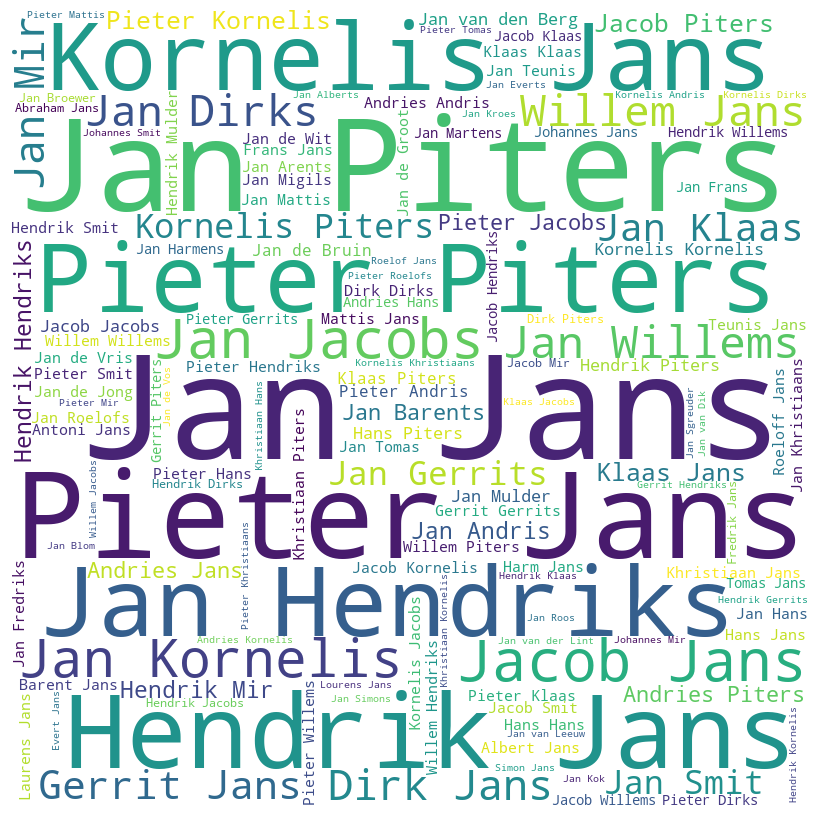

In [17]:
# Standardized Names
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(df.fullNameNormalized.value_counts())

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

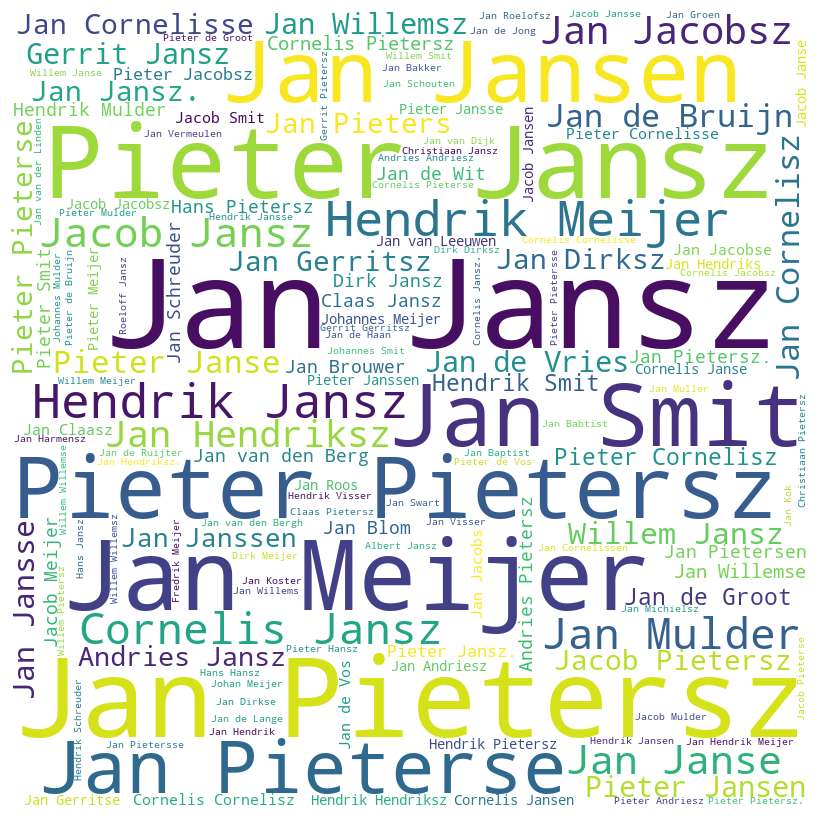

In [18]:
# Original Names
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate_from_frequencies(df.fullNameOriginal.value_counts())

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

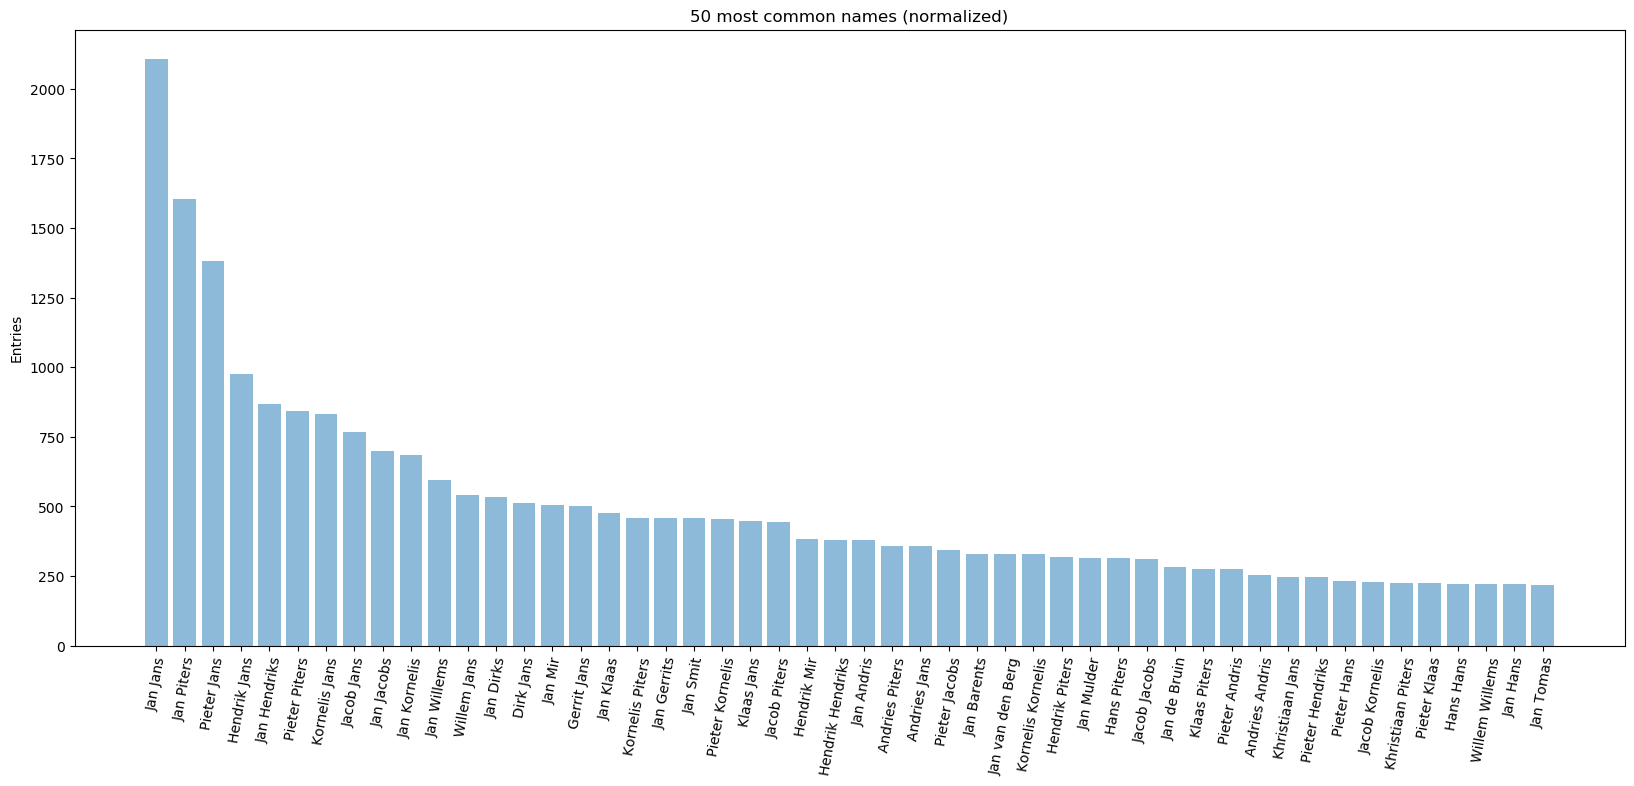

In [19]:
objects = [x for x in df.fullNameNormalized.value_counts().keys()[0:50]]
y_pos = np.arange(len(objects))
performance = [x for x in df.fullNameNormalized.value_counts()[0:50]]

plt.figure(figsize = (20, 8)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=80)
plt.ylabel('Entries')
plt.title('50 most common names (normalized)')

plt.show()

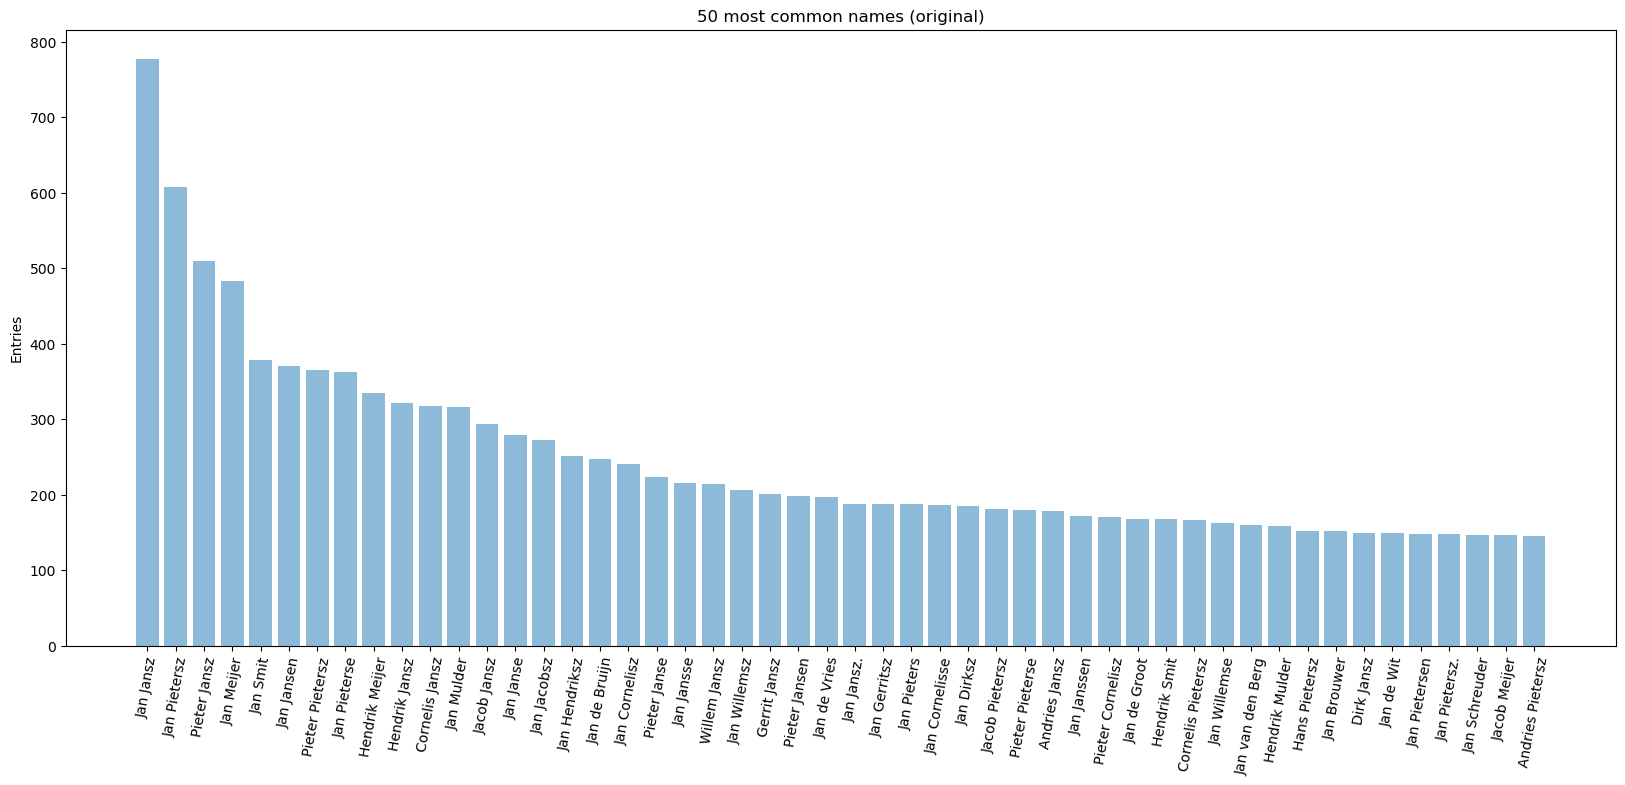

In [20]:
objects = [x for x in df.fullNameOriginal.value_counts().keys()[0:50]]
y_pos = np.arange(len(objects))
performance = [x for x in df.fullNameOriginal.value_counts()[0:50]]

plt.figure(figsize = (20, 8)) 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=80)
plt.ylabel('Entries')
plt.title('50 most common names (original)')

plt.show()


### Rang

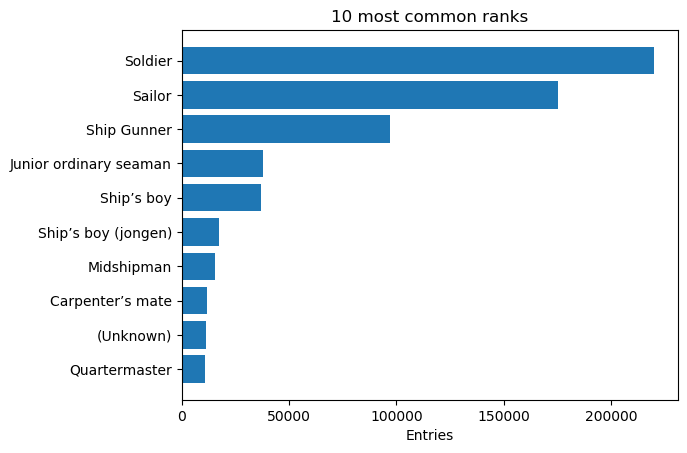

In [23]:
objects = [x for x in df['rank'].value_counts().keys()[0:10]]
y_pos = np.arange(len(objects))
performance = [x for x in df['rank'].value_counts()[0:10]]

fig, ax = plt.subplots()

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Entries')
ax.set_title('10 most common ranks')

plt.show()

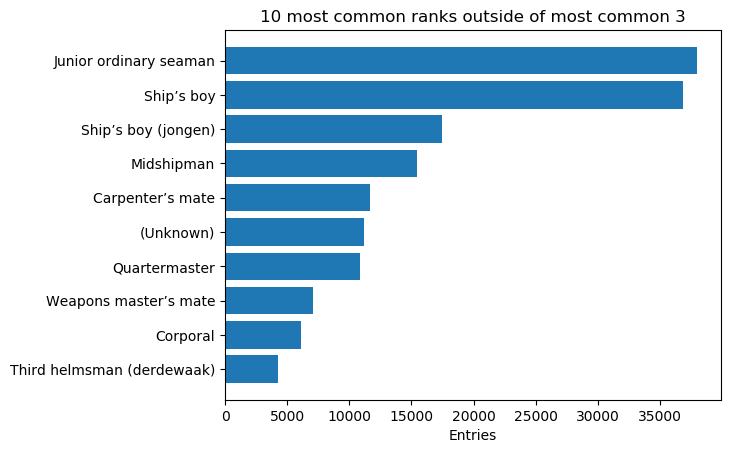

In [24]:
objects = [x for x in df['rank'].value_counts().keys()[3:13]]
y_pos = np.arange(len(objects))
performance = [x for x in df['rank'].value_counts()[3:13]]

fig, ax = plt.subplots()

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Entries')
ax.set_title('10 most common ranks outside of most common 3')

plt.show()

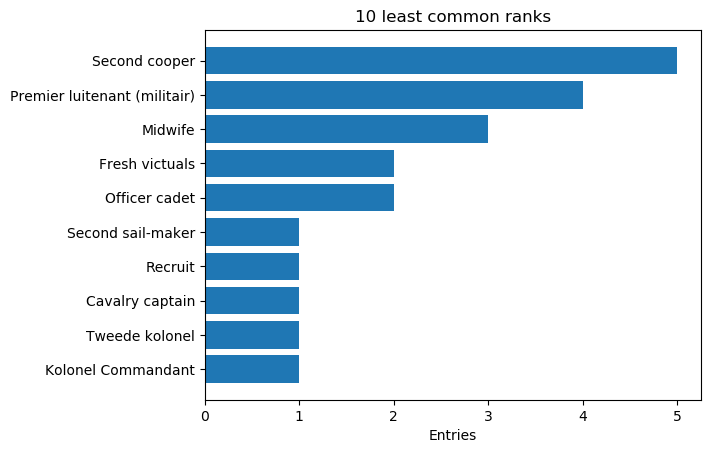

In [25]:
objects = [x for x in df['rank'].value_counts().keys()[-10:]]
y_pos = np.arange(len(objects))
performance = [x for x in df['rank'].value_counts()[-10:]]

fig, ax = plt.subplots()

ax.barh(y_pos, performance, align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(objects)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Entries')
ax.set_title('10 least common ranks')

plt.show()

## Cornelis Vis

Cornelis Vis was an employee of the VOC that made a voyage towards the west indies on a ship called the Huis te Spijk and returned on a ship called the Krabbendijke. He did this for the Kamer van Zeeland going outward, whilst he sailed for the Kamer van Asmterdam on the return journey. On both ships he held the rank of skipper, also known as captain, by this time. Most of this information is available in the voc clustered dataset, but one piece of information is not: the chamber that he sailed for, the Kamer van Zeeland and the Kamer van Amsterdam. Then how is it that this is known, despite it not being available in the dataset. The answer lies in a notary document created by the notary Jan Verleij. In the following text both Cornelis Vis and the chambers he sailed for are mentioned:

>No: 259 Procuratie gepoassseert den 19e: Septemberv7jdNet:AtleOp heden den 19 Feprenber des Jaars 1755 Compareerde voor mij Ja herleid Notaris publiek bij den Ed Ade: Holland geadmitteerd binnen Amsterd Residerende Jfo21 759 den 19e: Seplem� CConp 1745 d' E. Jan Govertsz van Fredrik Stad In den Jare 1744 voor Matroos mett g het Schipt huijste Spijk voor de Caamer Zeeland uijt gevaaren en de nu onlangs voor Bootsmans maat met 't Schip Crabbendijk Voor de Caamer Amsterdam uijtbostindien te ruij gekoomen en behoorlijk off gedankt Dewelke Verklaarde bij deese te Constitueeren de Heer Cornelis dis voor Capn: Luijtenant uijt ooff in dien gerepatrieert Tjeaalijk Omme tworderen en Ontfangen van d Ed heeren bewind hebbenen van de Bosjndeshe Compagnie ter samere Zeelaned voornt alle het Geene hij Compt voorgagien maand gelden als andersints mitsgaders voor hett douceur of Equivalent volgens het Regelement ^ en p penige wegens agteromkomen van Sr: 1745 ^ ter Camerl voornt te goede heeft voorden ontfangst te quiteeren en voor name ningen te staan borgen te Stellen ende Selve weeder bevuijding te belooven met magt van Substitutie en met belofte van Approbatie onder verband als na Regten Gepasseert n amsterdam voornt present Barend Melgerse van Laer en Jan de Ruijter als betuigen dit Xmerk gesteld bij Jan Govertsz Caarend Heegers Jan Jaan Jan de Ruijter Jan Ver Nots:

This text might be very hard to understand for anyone that is not a Dutch historian, since it is Handwritten Text Recognized text from a 18th century notary document. The gist of it is that another employee of the VOC, called Jan Govertsz, went to the notary Jan Verleij in order to make sure he was paid for the work he had done. Jan Govertsz told the notary who his captain was, as was custommary for the time. This resulted in Cornelis Vis to be entered into the document, along with the ships he was captain of and the chambers they sailed for. Making use of the recorded ship names, leave and return dates, and rank, the Cornelis Vis in the notary document was able to be linked to the Cornelis Vis in the voc clustered dataset.